# Training parameterized quantum circuits

In this tutorial, Parameterized Quantum Circuit (PQC) and its application on variational quantum eigensolvers (VQE) will be implemented in QuAIRKit.

**Table of Contents**

- [Introduction to Neural Networks](#Introduction-to-Neural-Networks)
- [Neural Networks in PyTorch](#Neural-Networks-in-PyTorch)
- [Parameterized quantum circuits (PQCs)](#Parameterized-quantum-circuits-(PQCs))
- [Variational quantum eigensolvers (VQEs)](#Variational-quantum-eigensolvers-(VQEs))

In [1]:
import time
from typing import Callable, List

import numpy as np
import torch
from matplotlib import pyplot as plt

import quairkit as qkit
from quairkit import Circuit, State, Hamiltonian
from quairkit.database import *
from quairkit.loss import *

In [2]:
qkit.set_seed(1797587035)  # set a seed for reproducibility

> The following section introduces the fundamentals of neural networks. For specific examples, you can proceed directly to the section on [variational quantum eigensolvers (VQEs)](#Variational-quantum-eigensolvers-(VQEs)).

## Introduction to Neural Networks
Neural networks are machine learning models that draw inspiration from the structure and function of the human brain. These networks are composed of layers of interconnected nodes, or artificial neurons, which include an input layer, one or more hidden layers, and an output layer. Each connection is characterized by weights and thresholds that influence how information is processed.

In a neural network, the fundamental unit is the neuron. It receives input signals, processes them, and generates an output. For instance, parameterized quantum gates, which operate in quantum neural networks (QNNs), can be viewed as analogous to neurons.

The neurons are organized into layers, where each layer transforms the input and passes it to the next. For example, a sequence of quantum gates like rotations and controlled-NOT (CNOT) gates can serve as a layer in a QNN.

Key to neural network function are the parameters, which are adjusted during training to optimize performance. These parameters, such as the angles in quantum rotation gates $U(\theta)$, are tuned to minimize the network's loss function. The loss function quantifies the error between the predicted and actual outputs, guiding the network toward more accurate predictions.

Common loss functions include the Mean Squared Error (MSE), Cross-Entropy Loss, and more specialized metrics such as state and gate infidelity. These functions measure discrepancies in various contexts, such as between probability distributions or quantum states.
- MSE measures the squared differences between predicted and actual outputs: $L(y,\hat{y}) = \frac{1}{2} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2 .$
- Cross-Entropy Loss is used in classification tasks: $L(y,\hat{y}) = - \sum_{i=1}^{m} y_i \log(\hat{y}_i) / m + (1-y_i) \log(1-\hat{y}_i) .$
- State Infidelity measures the overlap between two quantum states: $L(\rho, \hat{\rho}) = 1 - \operatorname{tr} \sqrt{\sqrt{\rho} \hat{\rho} \sqrt{\rho}} .$
- Gate Infidelity evaluates the difference between two quantum operations: $L(U, V) = 1 - \left| \operatorname{tr} \left( U^\dagger V \right) \right| / d .$


Forward propagation refers to the process of passing data through a neural network. In the context of a quantum neural network (QNN) with 
$N$ layers, denoted as $U_1 (\theta^{(1)}), \ldots, U_N (\theta^{(N)})$ , and an initial state $| \psi^{(0)} \rangle$. Then the output state of the $l$-th layer is computed as:
$$
| \psi^{(l)} \rangle = U_l (\theta^{(l)}) | \psi^{(l - 1)} \rangle
, \tag{1}$$
where $| \psi^{(l - 1)} \rangle$ represents the output state of the $(l-1)$-th layer. The final output state $| \psi^{(N)} \rangle$ is obtained by applying a loss function $L$, yielding the network’s final result.

Backpropagation is the process used to compute gradients of the parameters with respect to the loss function $L$. In particular, Continuing the previous example, the gradient for the parameter $\theta_j^{(l)}$ in the $l$-th layer is mathematically computed as

$$
\frac{\partial L}{\partial \theta_j^{(l)}} 
= \frac{\partial L}{\partial \psi^{(N)}} \cdot \frac{d \psi^{(N)}}{d \psi^{(N - 1)}} \cdot \ldots \cdot \frac{d \psi^{(l + 1)}}{d \psi^{(l)}} \cdot \frac{d \psi^{(l)}}{d \theta_j^{(l)}}
. \tag{2}$$

Once the gradients are determined, the parameters are updated using optimization methods such as gradient descent. The update rule for gradient descent is:
$$
\theta_j^{(l)} \leftarrow \theta_j^{(l)} - \eta \frac{\partial L}{\partial \theta_j^{(l)}}
, \tag{3}$$
where $\eta$ is the learning rate , a small value like $0.1$. ensuring steady convergence by controlling the step size in the direction of the negative gradient.

## Neural Networks in PyTorch

- Managing Parameters in torch.nn.Module

    In PyTorch, a neural network is implemented by creating a class that inherits from `torch.nn.Module`. Inside the  \_\_init\_\_ method, network parameters such as weights and biases are defined using `torch.nn.Parameter`. This setup ensures that PyTorch tracks and optimizes these parameters during training, simplifying the model definition and making it easy to integrate with PyTorch’s optimization and gradient computation tools.

- Backpropagation

    After the forward pass is executed in PyTorch, the model's loss is computed based on the predicted and actual outputs. Backpropagation is then performed by calling `.backward()` of the module. This function calculates the gradients of the loss with respect to all the learnable parameters of the model, preparing them for optimization in the next step.

- Gradient

    During backpropagation in PyTorch, the gradients of the loss with respect to each parameter are computed and stored in the  `grad` attribute of the respective parameters. These gradients are then used to update the model’s weights. If any data, such as `np.ndarray`, `float` or `torch.Tensor` is marked with `stop_gradient=True`, which means that it will be  treated as a constant and will not have gradients calculated, effectively excluding it from the optimization process.

- Updating Parameters

    After gradients are calculated, the parameters of the model are updated using an optimizer. The `step` method of the optimizer is called to apply these updates based on the calculated gradients. This step adjusts the parameters according to the specified optimization algorithm, moving the model closer to minimizing the loss function.

- Schedulers

    Schedulers in PyTorch are used to dynamically adjust the learning rate during training, helping to improve convergence and overall model performance. These schedulers modify the learning rate based on factors such as the number of epochs, the validation loss, or other predefined conditions. By gradually reducing the learning rate as training progresses, schedulers help smooth the optimization process, preventing overshooting and ensuring a more stable path towards the optimal solution.


## Parameterized quantum circuits (PQCs)

PQCs are critical components in variational quantum algorithms, where quantum gates depend on tunable parameters. These parameters are iteratively optimized through classical algorithms to minimize a specific cost function. PQCs play a pivotal role in exploring high-dimensional solution spaces, making them widely applicable in quantum machine learning, optimization, and quantum chemistry simulations. Their ability to leverage quantum superposition and entanglement allows for computationally efficient solutions to problems that are challenging for classical systems.

- Structure of PQCs
    - Rotation gates in PQCs are characterized by tunable angles, acting as adjustable weights, while fixed two-qubit gates are used to create entanglement within the circuit, enabling the interaction between qubits and enhancing the circuit's capability to represent complex quantum states.

    - PQCs can be conceptualized as a neural network, where the input layer corresponds to an initial quantum state and the output layer yields either a final quantum state or the expectation value of an observable, such as a Hamiltonian. The hidden layers are composed of quantum gates, including rotation gates that serve as tunable parameters.

    
- Training PQCs
    - PQCs are trained using classical optimization techniques aimed at minimizing a loss function. This loss is often associated with reaching a target quantum state or optimizing the expectation value of a quantum observable, such as a Hamiltonian. By iteratively adjusting the parameters of the quantum gates, these optimization methods guide the circuit toward improved performance, similar to how neural networks are trained in classical machine learning.
        
    - Backpropagation in the quantum circuit: parameter updates are performed using techniques such as parameter shift and gradient descent. These methods calculate the gradients of the loss function with respect to the parameters (angles) of the quantum gates.

## Variational quantum eigensolvers (VQEs)

- Background

    VQEs is a quantum algorithm designed to find the lowest eigenvalue of a Hamiltonian, which represents the total energy of a quantum system. This problem is crucial in quantum mechanics, as the eigenstates of a Hamiltonian reveal important system properties like energy levels and thermodynamic behavior. Although determining the exact ground state is computationally challenging, VQEs offers a practical approach by variationally approximating the ground state, making it valuable in fields such as quantum chemistry and materials science [1-5].

- Theoretical Framework

    According to the Rayleigh-Ritz variational principle [6-7], the expectation value of the Hamiltonian provides an lower bound for the true ground state energy. This principle underlies the VQEs approach by parameterizing a quantum state $\vert \psi(\theta)\rangle$ using a quantum circuit and iteratively optimizing the parameters to minimize the Hamiltonian's expectation value $\langle \psi(\theta)\vert H \vert\psi(\theta)\rangle$, VQEs seeks to approximate the system's true ground state,
    $$ \lambda_0 = \min_{\theta} \langle \psi(\theta)\vert H \vert\psi(\theta)\rangle,$$
    where $\lambda_0$ is approximately the ground state energy of the Hamiltonian $H$. 

- Application

    VQEs can be used to find the ground state energy of the Ising model, a two-dimensional model of ferromagnetism where atomic magnetic moments align. Despite its simplicity, the Ising model exhibits complex behaviors such as spontaneous magnetization and critical phenomena, making it a fundamental tool for understanding collective behavior in physical systems. Exact solutions and numerical simulations of the Ising model also provide insights into more complex systems and phenomena in statistical physics and condensed matter theory.
        
    For the following example, we consider a specific the Ising model is given by
    $$ H = - \sum_{i=1}^{N-1} Z_{i} Z_{i+1} + \sum_{i=1}^{N} X_{i}, \tag{4}$$
    where $X_{i}$ and $Z_{i}$ are the Pauli matrices, the external magnetic field strength is set to $1$, interaction strength on each pair of sites is uniform. 
   
    VQEs algorithm is able to find the ground state of the Hamiltonian, which is the lowest eigenvalue of the Hamiltonian. Here are details for implementing VQEs in QuAIRKit.

Construct a parameters circuit with predefined circuit templates in QuAIRKit.

In [3]:
def construct_cir(num_qubits: int, depth: int) -> Circuit:
    r"""Construct the quantum circuit for the variational quantum eigensolver.
    
    Args:
        num_qubits: number of qubits in the quantum circuit.
        depth: number of training layers in the circuit.
    
    Returns:
        the target quantum circuit
    
    """
    circuit = Circuit(num_qubits)

    # add qubit gates to the circuit
    circuit.complex_entangled_layer(qubits_idx=list(range(num_qubits)), depth=depth)

    return circuit

Define the loss function as the expectation value of $H$. 

In [4]:
def loss_fcn(cir: Circuit, exp_val: Callable[[State], torch.Tensor]) -> torch.Tensor:
    r"""Compute the loss function of the quantum neural network.
    
    Args:
        cir: the input PQC
        exp_val: the expectation value function
    
    Returns:
        the loss value

    """
    output = cir()  # input state is |0> state by default
    return exp_val(output)  # calculate the expectation value of the output state

Define the plot generation function to visualize the optimization process.

In [5]:
def display_results(loss_list: List[float], lambda_0: int, circuit: Circuit) -> None:
    r"""Plot the training process and the final circuit.

    Args:
        loss_list: the list of loss values during the training process
        lambda_0: the ground-state energy
        circuit: the final circuit

    """

    print("\n" + "-" * 100 + "\n")  # a line of '-' for better readability
    print("Circuit after training:")

    circuit.plot()  # plot the circuit

    num_itr = len(loss_list)
    base_line = lambda_0 * torch.ones(num_itr)
    list_itr = list(range(num_itr))


    print("\n" + "-" * 100 + "\n")  # a line of '-' for better readability
    print("Training process:")

    plt.plot(
        list_itr,
        loss_list,
        alpha=0.7,
        marker="",
        linestyle="-",
        color="r",
        label=r"$\left\langle {\psi \left( {\theta } \right)} \right|"
        + r"H\left| {\psi \left( {\theta } \right)} \right\rangle $",
    )
    plt.plot(
        list_itr,
        base_line,
        alpha=0.7,
        marker="",
        linestyle=":",
        color="b",
        label="Ground-state energy $\lambda_0$",
    )
    plt.xlabel("Number of iteration")
    plt.ylabel(r"Energy $\lambda_0$")
    plt.legend(loc="best")
    plt.show()

Construct the Neural Network model.

In [6]:
def train_model(num_itr: int, LR: float, num_qubits: int, depth: int, H: Hamiltonian) -> None:

    cir = construct_cir(num_qubits, depth)

    # calculate the eigenvalues and eigenvectors of the Hamiltonian
    eigenvalues = torch.linalg.eigvalsh(H.matrix)

    # take the minimum eigenvalue as the ground state energy
    lambda_0 = torch.min(torch.real(eigenvalues))

    # the expectation value operator of the Hamiltonian H
    exp_val = ExpecVal(H)

    loss_list, time_list = [], []

    # cir is a Circuit type
    opt = torch.optim.Adam(lr=LR, params=cir.parameters())

    # activate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, "min", factor=0.5)

    print("Training:")
    for itr in range(num_itr):
        start_time = time.time()
        opt.zero_grad()

        loss = loss_fcn(cir, exp_val)  # compute loss

        loss.backward()  # compute gradients
        opt.step()  # update parameters
        scheduler.step(loss)  # activate scheduler

        loss = loss.item()
        loss_list.append(loss)
        time_list.append(time.time() - start_time)

        if itr % 20 == 0 or itr == num_itr - 1:
            print(
                f"iter: {itr}, loss: {loss:.8f}, lr: {scheduler.get_last_lr()[0]:.2E}, avg_time: {np.mean(time_list):.4f}s"
            )
            time_list = []
    
    display_results(loss_list, lambda_0, cir)

Train the parameterized quantum circuit.

Training:
iter: 0, loss: -1.03517652, lr: 5.00E-02, avg_time: 0.0361s
iter: 20, loss: -2.40390968, lr: 5.00E-02, avg_time: 0.0113s
iter: 40, loss: -2.79073524, lr: 5.00E-02, avg_time: 0.0122s
iter: 60, loss: -3.16234064, lr: 5.00E-02, avg_time: 0.0111s
iter: 80, loss: -3.45437813, lr: 5.00E-02, avg_time: 0.0147s
iter: 100, loss: -3.48992562, lr: 5.00E-02, avg_time: 0.0105s
iter: 120, loss: -3.49346781, lr: 5.00E-02, avg_time: 0.0103s
iter: 140, loss: -3.49388337, lr: 5.00E-02, avg_time: 0.0119s
iter: 160, loss: -3.49395490, lr: 5.00E-02, avg_time: 0.0103s
iter: 180, loss: -3.49395800, lr: 5.00E-02, avg_time: 0.0130s
iter: 199, loss: -3.49395871, lr: 5.00E-02, avg_time: 0.0122s

----------------------------------------------------------------------------------------------------

Circuit after training:


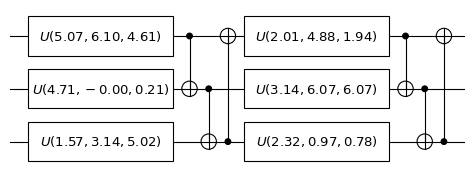


----------------------------------------------------------------------------------------------------

Training process:


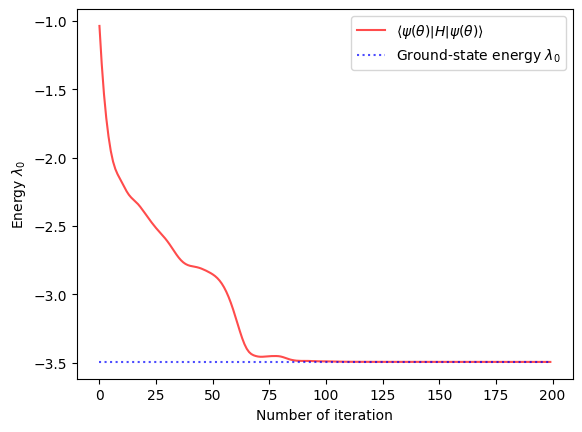

In [7]:
num_qubits = 3  # number of qubits in the system

NUM_ITR = 200  # number of iterations for training
LR = 0.05  # learning rate for training
depth = 2  # depth of the circuit

edges = -torch.tensor([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
vertices = torch.tensor([1, 1, 1])
hamiltonian = ising_hamiltonian(edges, vertices)  # the Ising Hamiltonian

train_model(NUM_ITR, LR, num_qubits, depth, hamiltonian)

---

## References

[1] Cao, Yudong, et al. "Quantum chemistry in the age of quantum computing." Chemical reviews 119.19 (2019): 10856-10915.

[2] McArdle, Sam, et al. "Quantum computational chemistry." Reviews of Modern Physics 92.1 (2020): 015003.

[3] Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." Nature communications 5.1 (2014): 4213.

[4] Moll, Nikolaj, et al. "Quantum optimization using variational algorithms on near-term quantum devices." Quantum Science and Technology 3.3 (2018): 030503.

[5] Tilly, Jules, et al. "The variational quantum eigensolver: a review of methods and best practices." Physics Reports 986 (2022): 1-128.

[6] Sakurai, J. J., and Jim Napolitano. Modern Quantum Mechanics. 3rd ed. Cambridge: Cambridge University Press, 2020. Print.

[7] Griffiths, David J., and Darrell F. Schroeter. Introduction to Quantum Mechanics. 3rd ed. Cambridge: Cambridge University Press, 2018. Print.

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
|  $L$ |   |   loss function|
|$\eta$ | |  learning rate|
| $\operatorname{tr}$ |   |   trace of a matrix|
|  $H$ |   |   matrix representation of the Hamiltonian|
|  $\lambda_0$ |   |   the minimum eigenvalue of the Hamiltonian|
| $U$ | $U(\theta)$ |  quantum gate/layer (parameterized by $\theta$)|
| $\vert \psi \rangle$ | $\vert \psi(\theta) \rangle$ |  pure state (parameterized by $\theta$)|
|  $X$, $Z$ |  $X_i$,  $Z_i$ |  Pauli matrices (on the $i$-th qubit)|

In [8]:
qkit.print_info()


---------VERSION---------
quairkit: 0.3.0
torch: 2.5.1+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.16
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
